This jupyter notebook is for data acquisition with Fouier ptychography microscope. 

The method is to light up the LEDs in the array sequentially from the center in a spiral pattern. This arrangement has the property that the first n^2 images correspond to the central nxn grid, from n=1->16. Additionally, the starting LED is always the same one (7,7), which is useful for reconstruction. 

In [1]:
from RPiCameraApp import RPiCameraApp
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import os
from PIL import Image
import time
from RPiLedMatrix import RPiLedMatrix
from picamera2 import Picamera2


# Custom functions
import fpm_functions as fpm 

In [63]:
# Clean up camera and LED array if they are stuck
led_matrix = RPiLedMatrix()
led_matrix.off()
camera = Picamera2()
camera.stop()
camera.close()

[2:25:33.087451601] [4510]  INFO Camera camera_manager.cpp:316 libcamera v0.3.1+50-69a894c4
[2:25:33.099456014] [7204]  INFO RPI pisp.cpp:695 libpisp version v1.0.7 28196ed6edcf 29-08-2024 (16:33:32)
[2:25:33.114551423] [7204]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a to CFE device /dev/media0 and ISP device /dev/media2 using PiSP variant BCM2712_C0


Camera app preview

In [62]:

led_matrix = RPiLedMatrix()
led_matrix.set_rotation(135) # 0,0 is bottom left
# led_matrix.show_circle(radius=3, color='black', outside_color='white') # darkfield
# led_matrix.show_circle(radius=3, color='white') # brightfield

# gridSize = 5
# i = 0
# x,y = fpm.LED_spiral(gridSize)
# led_matrix.show_pixel(x[i],y[i])
# led_matrix.show_square(side=2)
# 
led_matrix.show_pixels([(7,7),(8,8)])



# camera_app = RPiCameraApp()
# camera_app.run()

# led_matrix.off()
# led_matrix.close()

Take a dataset - must be manually aligned

In [38]:
# Gather grayscale images for Fourier ptychography
output_folder = 'data/recent' # should be an empty folder
gridSize = 1 # can use 1 for testing and alignment, then set to 16 to capture full dataset

led_matrix = RPiLedMatrix()
led_matrix.set_rotation(135) # ensure 0,0 is bottom left pixel

# set up camera - way to automate?
exposure = 50000 # in us, 50000 for bf 300000-500000 for main fpm images
crop_start_x = 200 # from left of image
crop_start_y = 400 # from top of image
crop_size = 800

camera = Picamera2()
still_config = camera.create_still_configuration(main={'size':(1456,1088)}, controls = {'ExposureTime':exposure, "AnalogueGain": 1})
camera.configure(still_config)
camera.start()

x,y = fpm.LED_spiral(gridSize) # generates arrays for x and y to turn on LEDs in spiral pattern

# take a brightfield image for comparison
led_matrix.show_circle(radius=3, color='white', brightness=1 )
time.sleep(1)
img_arr = camera.capture_array()[crop_start_y:crop_start_y+crop_size,crop_start_x:crop_start_x+crop_size] # capture and crop
img_pil = Image.fromarray(img_arr) # convert to pillow object
img_pil_gray = img_pil.convert('L') # convert to grayscale 
img_path = os.path.join(output_folder, 'brightfield.png') # create path name
img_pil_gray.save(img_path, format='PNG') # save as png 

# # take fpm images
# for i in range(len(x)):
#         led_matrix.show_pixel(x[i],y[i],brightness=1)
#         # time.sleep(0.1) # short pause for LED
#         img_arr = camera.capture_array()[crop_start_y:crop_start_y+crop_size,crop_start_x:crop_start_x+crop_size] # capture and crop
#         img_pil = Image.fromarray(img_arr) # convert to pillow object
#         img_pil_gray = img_pil.convert('L') # convert to grayscale 

#         img_path = os.path.join(output_folder, f'image_{i}.png') # create path name
#         img_pil_gray.save(img_path, format='PNG') # save as png 
        
        
led_matrix.off()
camera.stop()
camera.close()


[1:03:19.996483446] [4443]  INFO Camera camera_manager.cpp:316 libcamera v0.3.1+50-69a894c4
[1:03:20.010213389] [4506]  INFO RPI pisp.cpp:695 libpisp version v1.0.7 28196ed6edcf 29-08-2024 (16:33:32)
[1:03:20.027943457] [4506]  INFO RPI pisp.cpp:1154 Registered camera /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a to CFE device /dev/media0 and ISP device /dev/media2 using PiSP variant BCM2712_C0
[1:03:20.034040823] [4443]  INFO Camera camera.cpp:1191 configuring streams: (0) 1456x1088-BGR888 (1) 1456x1088-BGGR_PISP_COMP1
[1:03:20.034318606] [4506]  INFO RPI pisp.cpp:1450 Sensor: /base/axi/pcie@120000/rp1/i2c@80000/imx296@1a - Selected sensor format: 1456x1088-SBGGR10_1X10 - Selected CFE format: 1456x1088-PC1B


Visualise fpm images

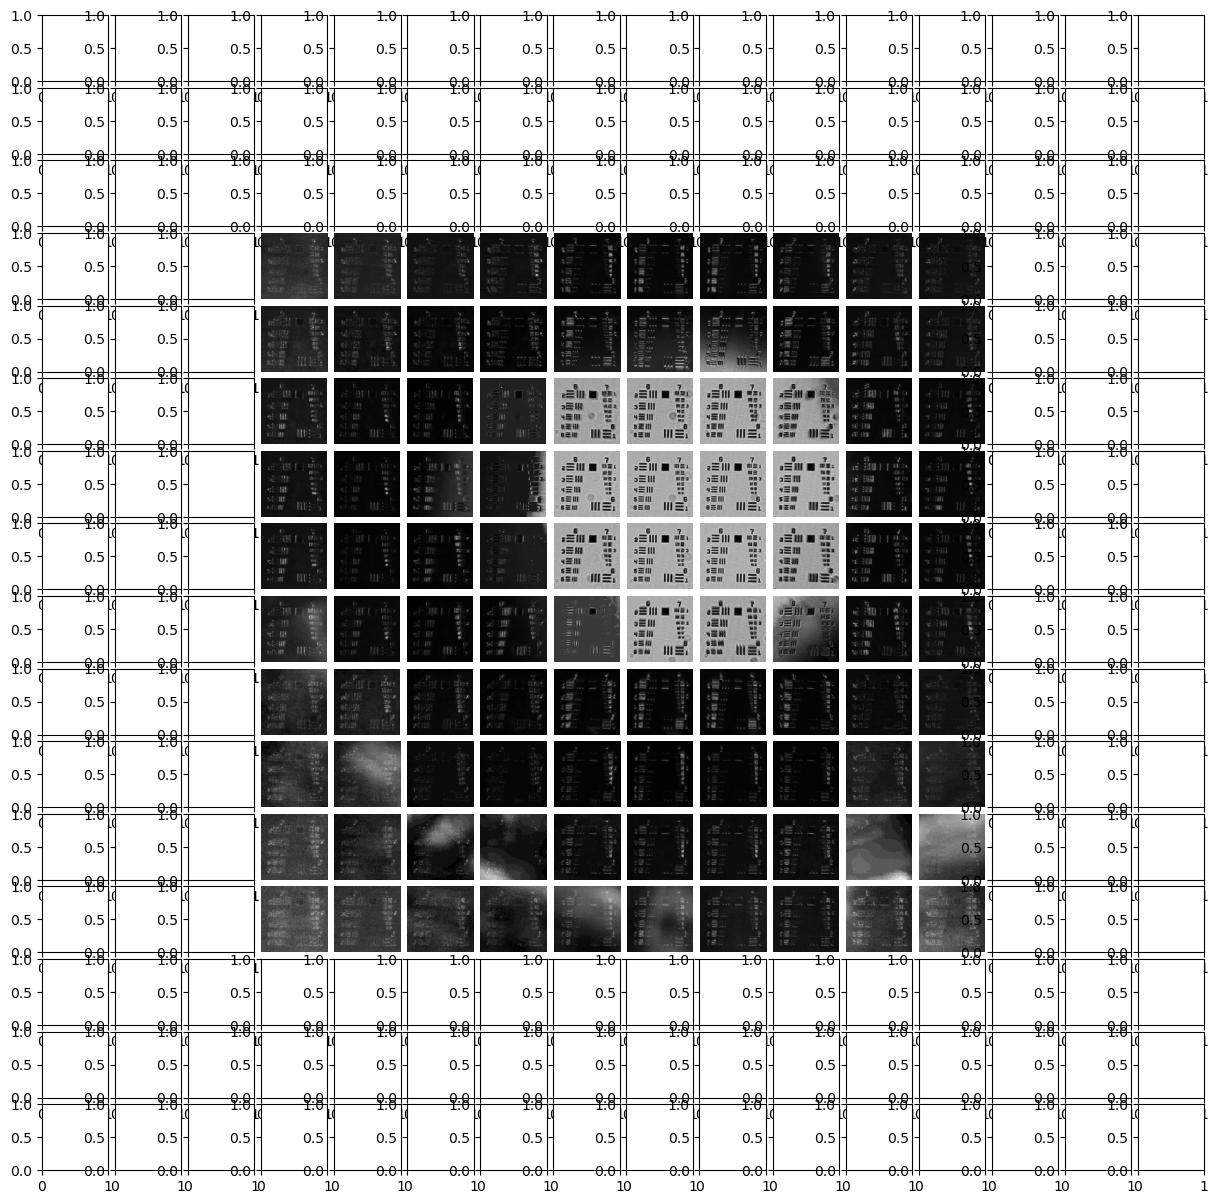

In [65]:
import fpm_functions as fpm 
fpm.display_data(grid_size=10,data_folder='data/recent')